# Trabalho 2 IART: Aprendizagem Supervisionada - Regressão
## Introdução
O futebol é possivelmente o desporto mais popular de sempre com milhões de adeptos e um igual número de jogadores dado ser talvez um dos desportos mais fáceis de jogar que existe.

Para além disso, este desporto movimenta uma grande quantidade de dinheiro quer pela venda de bilhetes e _merchandise_ quer pelas transferências de jogadores. Outro lado desta economia é o mercado das apostas desportivas que é cada vez mais procurado por adeptos. Sabe-se que os apostadores profissionais acertam na sua aposta cerca de 53% das vezes.

Sendo assim, o objetivo deste trabalho é prever o resultado de jogos de maneira a criar um sistema que recomenda o resultado do jogo em que apostar, preferivelmente com uma precisão superior à dos apostadores profissionais.

## Descrição do _dataset_
O _dataset_ inclui informação acerca de 25000 partidas de futebol em ligas de 11 países europeus realizadas nas épocas de 2008 a 2016 e acerca de 10000 jogadores. Este inclui ainda informação sobre os _odds_ fornecidos por vários _sites_ de apostas para os vários jogos.
Mais informação pode ser encontrada [aqui](https://www.kaggle.com/hugomathien/soccer).

## Aquisição e exploração de dados
O _dataset_ que irá ser usado corresponde a uma base de dados sqlite que inclui as tabelas a seguir apresentadas e que contêm a seguinte informação:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3

conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()
cursor.execute("select name from sqlite_master where type='table'; ")
cursor.fetchall()

[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',)]

* **Country:**  Países para os quais existe informação.
* **League:** Ligas de futebol dos vários países incluídos na tabela _Country_.
* **Match:** Informação sobre as várias partidas de futebol que inclui estatísticas do jogo, _odds_, bem como os jogadores que participaram.
* **Player:** Informação sobre os vários jogadores da base de dados, incluindo nome, data de nascimento, altura e peso.
* **Player_Attributes:** Habilidades de cada um dos jogadores tiradas do jogo FIFA.
* **Team:** Informação acerca de cada uma das equipas, incluindo o seu nome.
* **Team_Attributes:** Habilidades de cada uma das equipas tiradas do jogo FIFA.

Dado tratar-se de um _dataset_ extenso (~300MB) apenas serão consideradas partidas jogadas na English Premier League, já que corresponde a uma liga com um número razoável de equipas e jogos. Sendo assim, os passos seguintes têm como objetivo extrair informação acerca desta liga.

In [2]:
import pandas as pd

matches = pd.read_sql_query("select League.name, " 
                            "Match.id, Match.season, Match.possession, Match.corner, Match.card, Match.foulcommit as foul, "
                            "Match.shoton, Match.shotoff, T1.team_long_name as home_team, T1.team_api_id as home_team_id, " 
                            "home_team_goal, T2.team_api_id as away_team_id, T2.team_long_name as away_team, " 
                            "Match.away_team_goal, stage, date, B365H, B365D, B365A " 
                            "from League, Match on (League.id = Match.league_id), Team as T1 on (T1.team_api_id = Match.home_team_api_id), " 
                            "Team as T2 on (T2.team_api_id = Match.away_team_api_id) where League.name = 'England Premier League'", conn)

matches.head()

,name,id,season,possession,corner,card,foul,shoton,shotoff,home_team,home_team_id,home_team_goal,away_team_id,away_team,away_team_goal,stage,date,B365H,B365D,B365A
0,England Premier League,1729,2008/2009,<possession><value><comment>56</comment><event...,<corner><value><stats><corners>1</corners></st...,<card><value><comment>y</comment><stats><ycard...,<foulcommit><value><stats><foulscommitted>1</f...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,Manchester United,10260,1,10261,Newcastle United,1,1,2008-08-17 00:00:00,1.29,5.5,11.00
1,England Premier League,1730,2008/2009,<possession><value><comment>65</comment><event...,<corner><value><stats><corners>1</corners></st...,<card />,<foulcommit><value><stats><foulscommitted>1</f...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,Arsenal,9825,1,8659,West Bromwich Albion,0,1,2008-08-16 00:00:00,1.20,6.5,15.00
2,England Premier League,1731,2008/2009,<possession><value><comment>45</comment><event...,<corner><value><stats><corners>1</corners></st...,<card><value><comment>y</comment><stats><ycard...,<foulcommit><value><stats><foulscommitted>1</f...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,Sunderland,8472,0,8650,Liverpool,1,1,2008-08-16 00:00:00,5.50,3.6,1.67
3,England Premier League,1732,2008/2009,<possession><value><comment>50</comment><event...,<corner><value><stats><corners>1</corners></st...,<card><value><comment>y</comment><stats><ycard...,<foulcommit><value><stats><foulscommitted>1</f...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,West Ham United,8654,2,8528,Wigan Athletic,1,1,2008-08-16 00:00:00,1.91,3.4,4.20
4,England Premier League,1733,2008/2009,<possession><value><comment>51</comment><event...,<corner><value><stats><corners>1</corners></st...,<card><value><comment>y</comment><stats><ycard...,<foulcommit><value><stats><foulscommitted>1</f...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,Aston Villa,10252,4,8456,Manchester City,2,1,2008-08-17 00:00:00,1.91,3.4,4.33


Algumas colunas na tabela __Match__ contêm valores em XML (_possession_, _card_, _foul_, _corner_, _shoton_, _shotoff_). Portanto para obter estes valores relativamente a cada equipa é necessário realizar as seguintes operações, implementadas no ficheiro data_preparation.py.

In [3]:
from data_preparation import *

prepare_dataframe(matches)
extract_possession(matches)
extract_cards(matches)
extract_fouls(matches)
extract_corners(matches)
extract_shoton(matches)
extract_shotoff(matches)
cleanup(matches)

matches.head()

,name,id,season,home_team,home_team_id,home_team_goal,away_team_id,away_team,away_team_goal,stage,...,HR,AR,HF,AF,HC,AC,HST,AST,HS,AS
0,England Premier League,1729,2008/2009,Manchester United,10260,1,10261,Newcastle United,1,1,...,0,0,16,11,6,6,11,1,21,10
1,England Premier League,1730,2008/2009,Arsenal,9825,1,8659,West Bromwich Albion,0,1,...,0,0,11,9,7,5,12,2,25,5
2,England Premier League,1731,2008/2009,Sunderland,8472,0,8650,Liverpool,1,1,...,0,0,13,12,1,8,4,11,7,16
3,England Premier League,1732,2008/2009,West Ham United,8654,2,8528,Wigan Athletic,1,1,...,0,0,14,13,6,10,5,7,12,22
4,England Premier League,1733,2008/2009,Aston Villa,10252,4,8456,Manchester City,2,1,...,0,0,11,13,7,8,5,9,9,14


Vamos agora criar três novas colunas que representam para cada jogo o lado vencedor (equipa da casa ou equipa de fora) ou empate.

In [4]:
matches = matches.assign(home_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis='columns'),
              draw=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal == row.away_team_goal else 0, axis='columns'),
              away_win=lambda matches: matches.apply(lambda row: 1 if row.home_team_goal < row.away_team_goal else 0, axis='columns'))

Podemos agora calcular a taxa de vitórias, empates e derrotas em relação à equipa que joga em casa.

In [5]:
win_rates = matches.groupby('season') \
                   .mean() \
                   .loc[:, ['home_win', 'draw', 'away_win']]
win_rates

,home_win,draw,away_win
season,,,
2008/2009,0.455263,0.255263,0.289474
2009/2010,0.507895,0.252632,0.239474
2010/2011,0.471053,0.292105,0.236842
2011/2012,0.450000,0.244737,0.305263
2012/2013,0.436842,0.284211,0.278947
2013/2014,0.471053,0.205263,0.323684
2014/2015,0.452632,0.244737,0.302632
2015/2016,0.413158,0.281579,0.305263


Com estes dados podemos concluir que as equipas que jogam em casa têm uma maior possibilidade de vencer a partida.
Cerca de 46% dos jogos acabam com a vitória da equipa da casa, 28% acabam com vitória da equipa de fora e o acontecimento menos comum é o empate que ocorre em 26% dos jogos. Apresenta-se agora um gráfico com a evolução das taxas em estudo:

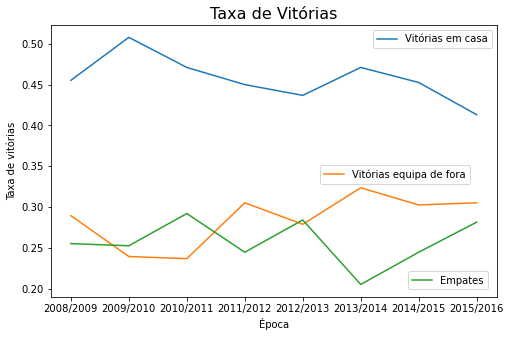

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)


home_line = ax.plot(win_rates.home_win, label='Vitórias em casa')
away_line = ax.plot(win_rates.away_win, label='Vitórias equipa de fora')
draw_line = ax.plot(win_rates.draw, label='Empates')
ax.set_xlabel("Época")
ax.set_ylabel("Taxa de vitórias")
plt.title("Taxa de Vitórias", fontsize=16)

# Add the legend locations
home_legend = plt.legend(handles=home_line, loc='upper right', bbox_to_anchor=(1, 1))
ax = plt.gca().add_artist(home_legend)
away_legend = plt.legend(handles=away_line, loc='center right', bbox_to_anchor=(0.95, 0.45))
ax = plt.gca().add_artist(away_legend)
draw_legend = plt.legend(handles=draw_line, loc='center right', bbox_to_anchor=(0.99, 0.06))

Podemos observar no gráfico que cada vez é mais difícil ter uma vitória em casa, parecendo ser cada vez mais provável haver um empate.

Uma medida interessante é quão vantajoso é para uma equipa, jogar em casa (HGA ou *Home Ground Advantage*) definido como a diferença entre a probabilidade da equipa ganhar em casa e a de ganhar fora.

In [7]:
home_win_rates = matches.groupby(['home_team']) \
                   .home_win \
                   .mean()

away_win_rates = matches.groupby(['away_team']) \
                   .away_win \
                   .mean()

hga = (home_win_rates - away_win_rates).reset_index().rename(columns={0: 'HGA'}).sort_values(by='HGA', ascending=False)
hga.head()

,home_team,HGA
16,Manchester City,0.335526
12,Fulham,0.289474
17,Manchester United,0.263158
25,Stoke City,0.263158
21,Portsmouth,0.236842


Mais interessante ainda é a variação desta medida ao longo do tempo para os vários clubes.

In [8]:
big_clubs = ['Liverpool', 'Manchester City', 'Manchester United', 'Chelsea', 'Arsenal']
home_win_rates_5 = matches[matches.home_team.isin(big_clubs)].groupby(['home_team', 'season']).home_win.mean()
away_win_rates_5 = matches[matches.away_team.isin(big_clubs)].groupby(['away_team', 'season']).away_win.mean()

hga_top_5 = home_win_rates_5 - away_win_rates_5

hga_top_5.unstack(level=0)

home_team,Arsenal,Chelsea,Liverpool,Manchester City,Manchester United
season,,,,,
2008/2009,0.105263,-0.157895,-0.052632,0.578947,0.210526
2009/2010,0.368421,0.368421,0.421053,0.315789,0.263158
2010/2011,0.157895,0.368421,0.368421,0.263158,0.684211
2011/2012,0.157895,0.315789,-0.105263,0.421053,0.105263
2012/2013,0.052632,0.105263,0.105263,0.263158,0.210526
2013/2014,0.105263,0.263158,0.315789,0.368421,-0.052632
2014/2015,0.105263,0.210526,0.105263,0.210526,0.421053
2015/2016,0.210526,-0.105263,0.000000,0.263158,0.263158


Apresenta-se a seguir um gráfico que representa a tabela acima.

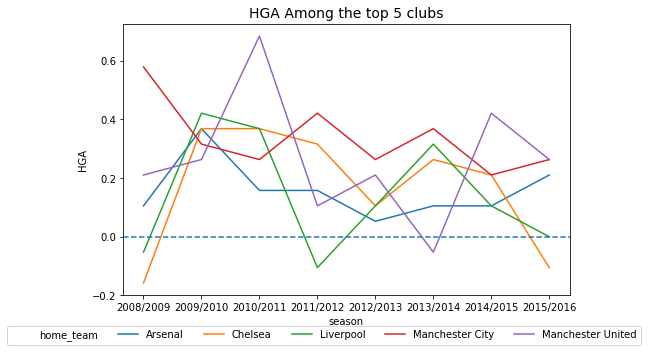

In [9]:
import seaborn as sns

plt.figure(figsize=(8, 5))
plot = sns.lineplot(x='season', y='HGA', hue='home_team', data=hga_top_5.reset_index().rename(columns={0: 'HGA', 'home_team': 'home_team'}))
plt.legend(loc='lower center', ncol=6, bbox_to_anchor=(0.45, -0.2))
plt.title("HGA Among the top 5 clubs", fontsize=14)

plot.axes.axhline(0, ls='--')

plt.show()

Os resultados são erráticos mas há duas equipas que têm esta medida sempre positiva (Arsenal e Manchester City). Interessantemente, algumas equipas, em algumas épocas ganharam mais jogos fora de casa do que em casa.

## Preparação dos Dados

O objetivo desta fase é preparar os dados para o processo de modelação e treino do modelo.

Sendo assim, criaram-se os seguintes dataframes para se poder perceber melhor o conteúdo do dataframe principal.
Legenda para as siglas:
* HS = Home Team Shots
* AS = Away Team Shots
* HST = Home Team Shots on Target
* AST = Away Team Shots on Target
* HC = Home Team Corners
* AC = Away Team Corners
* HF = Home Team Fouls Committed
* AF = Away Team Fouls Committed
* HY = Home Team Yellow Cards
* AY = Away Team Yellow Cards
* HR = Home Team Red Cards
* AR = Away Team Red Cards

In [14]:
stats = (matches
        .assign(date=lambda df: pd.to_datetime(df.date))
        .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1))  # Drop cols with NAs
        .dropna(axis=0)
        .sort_values('date')
        .reset_index(drop=True)
        .assign(id=lambda df: list(df.index + 1)))

stats_cols = ['id', 'home_team', 'away_team', 'home_team_goal', 'away_team_goal', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 
              'AC', 'HY', 'AY', 'HR', 'AR']

stats = matches[stats_cols].copy()
stats.head()

,id,home_team,away_team,home_team_goal,away_team_goal,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1729,Manchester United,Newcastle United,1,1,21,10,11,1,16,11,6,6,3,0,0,0
1,1730,Arsenal,West Bromwich Albion,1,0,25,5,12,2,11,9,7,5,0,0,0,0
2,1731,Sunderland,Liverpool,0,1,7,16,4,11,13,12,1,8,0,2,0,0
3,1732,West Ham United,Wigan Athletic,2,1,12,22,5,7,14,13,6,10,2,1,0,0
4,1733,Aston Villa,Manchester City,4,2,9,14,5,9,11,13,7,8,0,1,0,0


In [19]:
betting = (matches
            .assign(date=lambda df: pd.to_datetime(df.date))
            .pipe(lambda df: df.dropna(thresh=len(df) - 2, axis=1))
            .dropna(axis=0)
            .sort_values('date')
            .reset_index(drop=True)
            .assign(id=lambda df: list(df.index + 1), 
                    season=lambda df: df.date.apply(lambda row: row.year), 
                    home_win=lambda df: df.apply(lambda row: 1 if row.home_team_goal > row.away_team_goal else 0, axis=1),
                    away_win=lambda df: df.apply(lambda row: 1 if row.away_team_goal > row.home_team_goal else 0, axis=1),
                    result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1)))

betting_cols = ['B365A', 'B365D', 'B365H', 'home_win', 'away_win', 'result', 'home_team', 'away_team', 'id']

betting = betting[betting_cols].copy()
betting.head()

,B365A,B365D,B365H,home_win,away_win,result,home_team,away_team,id
0,15.00,6.5,1.20,1,0,home,Arsenal,West Bromwich Albion,1
1,1.67,3.6,5.50,0,1,away,Sunderland,Liverpool,2
2,4.20,3.4,1.91,1,0,home,West Ham United,Wigan Athletic,3
3,4.00,3.3,2.00,0,1,away,Everton,Blackburn Rovers,4
4,2.25,3.4,3.20,1,0,home,Middlesbrough,Tottenham Hotspur,5


### Criação de features

Uma vez tendo os dataframes preparados, vamos mover para a criação de _features_, comum em modelação de desportos creando médias móveis exponenciais (EMA) como _features_. Esta média dá um peso aos valores mais recentes superior ao dado a valores mais antigos, segundo um parâmetro alpha. Segue-se uma função para calcular a média movel exponencial com um valor de alpha igual a 5.

In [15]:
# Define a function which restructures our DataFrame
def create_multiline_df_stats(old_stats_df):
    # Create a list of columns we want and their mappings to more interpretable names
    home_stats_cols = ['home_team', 'home_team_goal', 'away_team_goal', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
    
    away_stats_cols = ['away_team', 'away_team_goal', 'home_team_goal', 'AS', 'HS', 'AST', 'HST', 'AF', 'HF', 'AC', 'HC', 'AY', 'HY',
                       'AR', 'HR']
    
    
    stats_cols_mapping = ['team', 'goals_for', 'goals_against', 'shots_for', 'shots_against', 'shots_on_target_for', 
                          'shots_on_target_against', 'frees_for', 'frees_against', 'corners_for', 'corners_against', 'yellows_for',
                          'yellows_against', 'reds_for', 'reds_against']
    
    # Create a dictionary of the old column names to new column names
    home_mapping = {old_col: new_col for old_col, new_col in zip(home_stats_cols, stats_cols_mapping)}
    away_mapping = {old_col: new_col for old_col, new_col in zip(away_stats_cols, stats_cols_mapping)}
    
    # Put each team onto an individual row
    multi_line_stats = old_stats_df[['id'] + home_stats_cols] \
                        .rename(columns=home_mapping) \
                        .assign(home_game=1) \
                        .append((old_stats_df[['id'] + away_stats_cols]) \
                                .rename(columns=away_mapping) \
                                .assign(home_game=0), sort=True) \
                        .sort_values(by='id') \
                        .reset_index(drop=True)
    return multi_line_stats

In [16]:
# Define a function which creates an EMA DataFrame from the stats DataFrame
def create_stats_features_ema(stats, span):
    # Create a restructured DataFrames so that we can calculate EMA
    multi_line_stats = create_multiline_df_stats(stats)
    
    # Create a copy of the DataFrame
    ema_features = multi_line_stats[['id', 'team', 'home_game']].copy()
    
    # Get the columns that we want to create EMA for
    feature_names = multi_line_stats.drop(columns=['id', 'team', 'home_game']).columns
    
    # Loop over the features
    for feature_name in feature_names:
        feature_ema = (multi_line_stats.groupby('team')[feature_name] # Calculate the EMA
                                                  .transform(lambda row: row.ewm(span=span, min_periods=2)
                                                             .mean()
                                                             .shift(1))) # Shift the data down 1 so we don't leak data
        ema_features[feature_name] = feature_ema # Add the new feature to the DataFrame
    return ema_features

# Apply the function
stats_features = create_stats_features_ema(stats, span=5)
stats_features.tail()

,id,team,home_game,corners_against,corners_for,frees_against,frees_for,goals_against,goals_for,reds_against,reds_for,shots_against,shots_for,shots_on_target_against,shots_on_target_for,yellows_against,yellows_for
6075,4766,Tottenham Hotspur,1,5.713331,6.222287,8.692983,15.302275,1.226715,1.999386,0.044666,7.179823e-08,13.902190,16.613955,8.323830,10.426690,1.368760,3.244888
6076,4767,Arsenal,0,4.847508,5.410389,13.094754,9.296246,0.829261,2.681730,0.066069,2.971243e-01,10.848183,14.891541,6.859595,8.836326,2.333193,1.275097
6077,4767,Watford,1,4.914168,4.200376,11.965246,13.413176,1.106115,0.920109,0.019735,1.004870e-01,11.804369,11.677967,7.219333,5.749809,1.665987,1.988224
6078,4768,West Bromwich Albion,1,5.484118,4.910318,9.988809,10.658089,1.509859,0.755906,0.133610,8.338585e-06,13.528982,8.248155,9.360880,4.414278,2.169245,2.000721
6079,4768,Sunderland,0,6.668829,2.662775,11.909395,14.710468,2.044343,1.031155,0.030056,4.814815e-01,15.299957,9.381822,8.640621,5.184282,2.096880,2.890987


In [17]:
pd.DataFrame(stats_features.groupby('team')
                           .goals_for
                           .mean()
                           .sort_values(ascending=False)[:10])

,goals_for
team,
Manchester City,1.972752
Chelsea,1.923804
Manchester United,1.913953
Arsenal,1.877293
Liverpool,1.753201
Tottenham Hotspur,1.588103
Blackpool,1.483772
Leicester City,1.461714
Everton,1.447586


### Otimizar o Alpha

Ao desenvolver o projeto, pensamos que um alpha de 5 seria um valor arbitrário e que podia não ser aquele que dava a melhor média possível, portanto decidimos otimizá-lo.

In [20]:
def restructure_stats_features(stats_features):
    non_features = ['home_game', 'team', 'id']

    stats_features_restructured = (stats_features.query('home_game == 1')
                                    .rename(columns={col: 'f_' + col + 'Home' for col in stats_features.columns if col not in non_features})
                                    .rename(columns={'team': 'home_team'})
                                    .pipe(pd.merge, (stats_features.query('home_game == 0')
                                                        .rename(columns={'team': 'away_team'})
                                                        .rename(columns={col: 'f_' + col + 'Away' for col in stats_features.columns 
                                                                         if col not in non_features})), on=['id'])
                                    .pipe(pd.merge, betting[['id', 'result']], on='id')
                                    .dropna())
    return stats_features_restructured

restructure_stats_features(stats_features).head()

,id,home_team,home_game_x,f_corners_againstHome,f_corners_forHome,f_frees_againstHome,f_frees_forHome,f_goals_againstHome,f_goals_forHome,f_reds_againstHome,...,f_goals_forAway,f_reds_againstAway,f_reds_forAway,f_shots_againstAway,f_shots_forAway,f_shots_on_target_againstAway,f_shots_on_target_forAway,f_yellows_againstAway,f_yellows_forAway,result
20,1749,Manchester United,1,3.0,4.2,13.4,13.0,0.4,1.6,0.0,...,0.8,0.0,0.0,16.6,10.6,3.4,4.4,1.2,1.2,draw
21,1750,Tottenham Hotspur,1,8.2,4.2,9.8,14.0,3.2,2.8,0.0,...,1.0,0.0,0.0,5.2,18.4,2.2,9.8,1.8,0.8,home
22,1751,Everton,1,4.6,3.0,14.6,12.2,1.2,1.4,0.0,...,1.6,0.0,0.0,8.8,9.4,4.4,2.2,2.4,0.0,away
23,1752,Middlesbrough,1,5.4,4.6,12.8,12.8,0.4,2.0,0.0,...,0.8,0.0,0.0,20.2,8.4,9.4,3.8,1.0,2.0,draw
24,1753,Newcastle United,1,7.2,6.6,13.6,13.4,1.0,1.6,0.0,...,3.4,0.0,0.0,13.4,7.8,7.8,3.2,1.0,0.0,draw


In [21]:
def optimise_alpha(features):
    le = LabelEncoder()
    y = le.fit_transform(features.result) # Encode the result from away, draw, home win to 0, 1, 2
    X = features[[col for col in features.columns if col.startswith('f_')]] # Only get the features - these all start with f_
    lr = LogisticRegression(max_iter=1000)
    
    kfold = StratifiedKFold(n_splits=5)
    ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
    return ave_cv_score

In [22]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

best_score = np.float('inf')
best_span = 0
cv_scores = []

# Iterate over a range of spans
for span in range(20, 90, 5):
    stats_features = create_stats_features_ema(stats, span=span)
    restructured_stats_features = restructure_stats_features(stats_features)
    cv_score = optimise_alpha(restructured_stats_features)
    cv_scores.append(cv_score)
    
    if cv_score * -1 < best_score:
        best_score = cv_score * -1
        best_span = span

c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

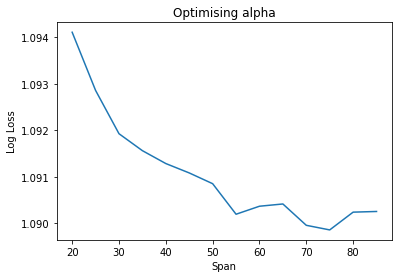

Log loss mais baixo (1.089859) ocorreu com um span de 75


In [24]:
import matplotlib.pyplot as plt
plt.plot(list(range(20, 90, 5)), (pd.Series(cv_scores)*-1)) # Plot our results

plt.title("Optimising alpha")
plt.xlabel("Span")
plt.ylabel("Log Loss")
plt.show()

print("Log loss mais baixo ({:2f}) ocorreu com um span de {}".format(best_score, best_span))

In [25]:
features_stats = create_stats_features_ema(stats, span=best_span)
features_stats.tail(3)

,id,team,home_game,corners_against,corners_for,frees_against,frees_for,goals_against,goals_for,reds_against,reds_for,shots_against,shots_for,shots_on_target_against,shots_on_target_for,yellows_against,yellows_for
6077,4767,Watford,1,6.172303,4.385713,10.629954,12.113886,1.321310,1.021054,0.077718,0.089370,11.812783,10.711964,6.263818,5.652388,1.228884,1.978950
6078,4768,West Bromwich Albion,1,5.586176,5.001793,10.740431,10.552447,1.331041,0.966388,0.117449,0.058731,12.831688,9.324837,6.928639,4.520602,1.247133,1.654127
6079,4768,Sunderland,0,5.947354,4.345448,11.288606,11.181531,1.560686,1.130225,0.114968,0.080617,13.883504,10.022196,7.572589,4.912204,1.794005,1.982218


### Execução dos algoritmos

Para analisarmos os dados escolhemos os algoritmos Logistic Regression, K-Nearest-Neighbours e Support Vector Machines pois são os mais adequados para os dados que temos. Segue-se a inicialização dos dados de treino e dados de teste.

In [36]:
from sklearn import linear_model, tree, discriminant_analysis, naive_bayes, ensemble, gaussian_process
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix
    
matches = matches.assign(result=lambda df: df.apply(
                            lambda row: 'home' if row.home_team_goal > row.away_team_goal else ('draw' if row.home_team_goal == row.away_team_goal else 'away'), axis=1))
matches.head()

matches = matches.fillna(matches.mean())
matches = matches.rename(columns={
        'B365H': 'f_homeOdds',
        'B365A': 'f_awayOdds',
        'B365D': 'f_drawOdds'
        })


feature_list = [col for col in matches.columns if col.startswith("f_")]

le = LabelEncoder() # Initiate a label encoder to transform the labels 'away', 'draw', 'home' to 0, 1, 2

# Grab all seasons except for 15/16 to use CV with
all_x = matches.loc[matches.season != '2015/2016', ['id'] + feature_list]
all_y = matches.loc[matches.season != '2015/2016', 'result']
all_y = le.fit_transform(all_y)

# Create our training vector as the seasons except 14/15 and 15/16
train_x = matches.loc[~matches.season.isin(['2014/2015', '2015/2016']), ['id'] + feature_list]
train_y = le.transform(matches.loc[~matches.season.isin(['2014/2015', '2015/2016']), 'result'])

# Create our holdout vectors as the 14/15 season
holdout_x = matches.loc[matches.season == '2014/2015', ['id'] + feature_list]
holdout_y = le.transform(matches.loc[matches.season == '2014/2015', 'result'])

# Create our test vectors as the 15/16 season
test_x = matches.loc[matches.season == '2015/2016', ['id'] + feature_list]
test_y = le.transform(matches.loc[matches.season == '2015/2016', 'result'])

Segue-se a execução de cada um dos 3 algoritmos escolhidos, começando pelo Logistic Regression:

c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\gonca\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not conv

Best log loss: 0.9684228400302028
Our predictions for the 2015/16 season have an accuracy of: 0.457895
Odds predictions for the 2015/16 season have a log loss of: 1.03524 and an accuracy of: 0.471


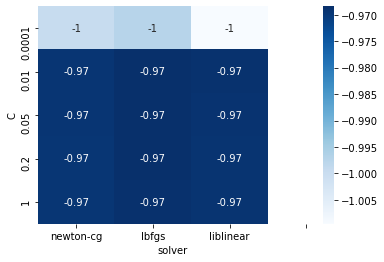

In [59]:
from sklearn.linear_model import LogisticRegression
import seaborn as sb

# Define our parameters to run a grid search over
lr_grid = {
    "C": [0.0001, 0.01, 0.05, 0.2, 1],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

kfold = StratifiedKFold(n_splits=5)

gs = GridSearchCV(LogisticRegression(), param_grid=lr_grid, cv=kfold, scoring='neg_log_loss')
gs.fit(all_x, all_y)
print("Best log loss: {}".format(gs.best_score_ *-1))
best_lr_params = gs.best_params_

grid_visualization = gs.cv_results_['mean_test_score']
grid_visualization.shape = (5, 3)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, gs.param_grid['solver'])
plt.yticks(np.arange(5) + 0.5, gs.param_grid['C'])
plt.xlabel('solver')
plt.ylabel('C')


# Get test predictions
lr = LogisticRegression(**best_lr_params) # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x) # Predict the holdout values

test_lr = LogisticRegression(**best_lr_params)
test_lr.fit(all_x, all_y)
# test_predictions_probs = lr.predict_proba(test_x)
test_predictions = lr.predict(test_x)

# test_ll = log_loss(test_y, test_predictions_probs)
test_accuracy = (test_predictions == test_y).mean()

print("Our predictions for the 2015/16 season have an accuracy of: {0:2f}".format(test_accuracy))

# Get accuracy and log loss based on the odds
odds_ll = log_loss(test_y, 1 / test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

odds_predictions = test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']].apply(lambda row: row.idxmin()[2:6], axis=1).values
odds_accuracy = (odds_predictions == le.inverse_transform(test_y)).mean()

print("Odds predictions for the 2015/16 season have a log loss of: {0:.5f} and an accuracy of: {1:.3f}".format(odds_ll, odds_accuracy))

In [50]:
from sklearn.neighbors import KNeighborsClassifier

# Define our parameters to run a grid search over
lr_grid = {
    "weights": ['uniform', 'distance'],
    "algorithm": ["ball_tree", "kd_tree", "brute"]
}

kfold = StratifiedKFold(n_splits=5)

gs = GridSearchCV(KNeighborsClassifier(), param_grid=lr_grid, cv=kfold, scoring='neg_log_loss')
gs.fit(all_x, all_y)
print("Best log loss: {}".format(gs.best_score_ *-1))
best_lr_params = gs.best_params_

# Get test predictions
lr = KNeighborsClassifier(**best_lr_params) # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x) # Predict the holdout values

test_lr = KNeighborsClassifier(**best_lr_params)
test_lr.fit(all_x, all_y)
# test_predictions_probs = lr.predict_proba(test_x)
test_predictions = lr.predict(test_x)

# test_ll = log_loss(test_y, test_predictions_probs)
test_accuracy = (test_predictions == test_y).mean()

print("Our predictions for the 2015/16 season have an accuracy of: {0:2f}".format(test_accuracy))

# Get accuracy and log loss based on the odds
odds_ll = log_loss(test_y, 1 / test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

odds_predictions = test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']].apply(lambda row: row.idxmin()[2:6], axis=1).values
odds_accuracy = (odds_predictions == le.inverse_transform(test_y)).mean()

print("Odds predictions for the 2015/16 season have a log loss of: {0:.5f} and an accuracy of: {1:.3f}".format(odds_ll, odds_accuracy))

Best log loss: 23.63113240077084
Our predictions for the 2015/16 season have an accuracy of: 0.413158
Odds predictions for the 2015/16 season have a log loss of: 1.03524 and an accuracy of: 0.471


In [54]:
from sklearn import svm

# Get test predictions
lr = svm.SVC() # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x) # Predict the holdout values

test_lr = svm.SVC()
test_lr.fit(all_x, all_y)
# test_predictions_probs = lr.predict_proba(test_x)
test_predictions = lr.predict(test_x)

# test_ll = log_loss(test_y, test_predictions_probs)
test_accuracy = (test_predictions == test_y).mean()

print("Our predictions for the 2015/16 season have an accuracy of: {0:2f}".format(test_accuracy))

# Get accuracy and log loss based on the odds
odds_ll = log_loss(test_y, 1 / test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

odds_predictions = test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']].apply(lambda row: row.idxmin()[2:6], axis=1).values
odds_accuracy = (odds_predictions == le.inverse_transform(test_y)).mean()

print("Odds predictions for the 2015/16 season have a log loss of: {0:.5f} and an accuracy of: {1:.3f}".format(odds_ll, odds_accuracy))


Our predictions for the 2015/16 season have an accuracy of: 0.413158
Odds predictions for the 2015/16 season have a log loss of: 1.03524 and an accuracy of: 0.471


In [47]:
from sklearn.naive_bayes import GaussianNB

# Get test predictions
lr = GaussianNB() # Instantiate the model
lr.fit(train_x, train_y) # Fit our model
lr_predict = lr.predict(holdout_x) # Predict the holdout values

test_lr = GaussianNB()
test_lr.fit(all_x, all_y)
# test_predictions_probs = lr.predict_proba(test_x)
test_predictions = lr.predict(test_x)

# test_ll = log_loss(test_y, test_predictions_probs)
test_accuracy = (test_predictions == test_y).mean()

print("Our predictions for the 2015/16 season have an accuracy of: {0:2f}".format(test_accuracy))

# Get accuracy and log loss based on the odds
odds_ll = log_loss(test_y, 1 / test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']])

odds_predictions = test_x[['f_awayOdds', 'f_drawOdds', 'f_homeOdds']].apply(lambda row: row.idxmin()[2:6], axis=1).values
odds_accuracy = (odds_predictions == le.inverse_transform(test_y)).mean()

print("Odds predictions for the 2015/16 season have a log loss of: {0:.5f} and an accuracy of: {1:.3f}".format(odds_ll, odds_accuracy))


Our predictions for the 2015/16 season have an accuracy of: 0.428947
Odds predictions for the 2015/16 season have a log loss of: 1.03524 and an accuracy of: 0.471


Com estas execuções verifica-se que as odds prevêm corretamente o resultado de cerca de 47% dos jogos. O LogisticRegression prevê corretamente 45.7% dos resultados, o k-Neighbors e o Support Vector Machine alcançam uma precisão de 41.3% e por último, o Gaussian Naïve Bayes, uma precisão de 42.8%.

In [60]:
fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
tp = np.diag(confusion_matrix)
tn = confusion_matrix.values.sum() - (fp + fn + tp)

# Recall
recall = tp/(tp+fn)
# Specificity or true negative rate
tnr = tn/(tn+fp) 
# Precision or positive predictive value
ppv = tp/(tp+fp)
# Negative predictive value
npv = tn/(tn+fn)
# Fall out or false positive rate
fpr = fp/(fp+tn)
# False negative rate
fnr = fn/(tp+fn)
# False discovery rate
fdr = fp/(tp+fp)

# Overall accuracy
accuracy = (tp+tn)/(tp+fp+fn+tn)

print("Sensitivity, hit rate, recall, or true positive rate: {}\n".format(recall))
print("Specificity or true negative rate {}\n".format(tnr))
print("Precision or positive predictive value: {}\n".format(ppv))
print("Negative predictive value: {}\n".format(npv))
print("Fall out or false positive rate: {}\n".format(FPR))
print("False negative rate: {}\n".format(fnr))
print("False discovery rate: {}\n".format(fdr))
print("Overall accuracy: {}".format(accuracy))

AttributeError: 'function' object has no attribute 'sum'